In [2]:
import pandas as pd
import numpy as np

In [21]:
df = pd.read_csv("ctr_result.csv")

In [22]:
df.head(5)

,set,dicom_id,ctr_gt,ctr_pred
0,train,a7953176-9008896f-73bd9d51-bbab3ee5-29870849,0.570370,0.570370
1,train,0af88fb2-48be6fe1-ec6ae812-e1915dbf-d701c3f2,0.512500,0.508600
2,train,f2752986-321bbedc-3b52b73f-1c8ea50c-9b7f233a,0.497788,0.495633
3,train,2e46c4ca-d0edfde8-4b1e1476-c440055b-9930a999,0.443678,0.408353
4,train,0e2da23c-6f63ffb5-62914e87-42bc37b8-3e9dfa97,0.603406,0.618227


In [23]:
df["set"].value_counts()

set
train    379
val       71
test      24
Name: count, dtype: int64

In [27]:
import os

# 1) Paths
meta_dir  = "CXR-metadata"
neg_fp    = os.path.join(meta_dir, "negative_cardiomegaly_with_ctr.csv")
pos_fp    = os.path.join(meta_dir, "positive_cardiomegaly_with_ctr.csv")
ctr_fp    = "ctr_result.csv"    # your file with dicom_id + ctr_gt/ctr_pred

# 2) Read & label
neg_df = pd.read_csv(neg_fp)

pos_df = pd.read_csv(pos_fp)

# 3) Concatenate into one label table
labels = pd.concat([
    neg_df[["dicom_id", "Cardiomegaly"]],
    pos_df[["dicom_id", "Cardiomegaly"]]
], ignore_index=True)

# 4) Read your CTR results
ctr_df = pd.read_csv(ctr_fp)    # must have a `dicom_id` column

# 5) Merge to get CTR + cardiomegaly flag
df_merged = ctr_df.merge(labels, on="dicom_id", how="left")

# Optionally check for any missing labels
missing = df_merged["Cardiomegaly"].isna().sum()
print(f"Missing cardiomegaly label for {missing} rows")

# 6) Save out
out_fp = "ctr_with_label.csv"
df_merged.to_csv(out_fp, index=False)
print(f"Wrote combined CSV → {out_fp}")


Missing cardiomegaly label for 236 rows
Wrote combined CSV → ctr_with_label.csv


In [28]:
df_merged

,set,dicom_id,ctr_gt,ctr_pred,Cardiomegaly
0,train,a7953176-9008896f-73bd9d51-bbab3ee5-29870849,0.570370,0.570370,1.0
1,train,0af88fb2-48be6fe1-ec6ae812-e1915dbf-d701c3f2,0.512500,0.508600,0.0
2,train,f2752986-321bbedc-3b52b73f-1c8ea50c-9b7f233a,0.497788,0.495633,NaN
3,train,2e46c4ca-d0edfde8-4b1e1476-c440055b-9930a999,0.443678,0.408353,1.0
4,train,0e2da23c-6f63ffb5-62914e87-42bc37b8-3e9dfa97,0.603406,0.618227,1.0
...,...,...,...,...,...
469,test,38d8a3fc-aa967df5-48821336-3be5f767-d22ef621,0.628647,0.631016,1.0
470,test,174999c0-0acff76e-4e8ce00a-df61ca75-d721632d,0.511936,0.474820,NaN
471,test,12051696-cc45d06c-0a3b4ede-1b1ce185-e748f154,0.631579,0.650538,1.0
472,test,c132e8d7-82554efa-c235143a-2044da6b-aa62f65c,0.583519,0.583333,1.0


In [53]:
# 1) Load your merged CSV
df = pd.read_csv("ctr_with_label.csv")  # or however you named it

# 2) Drop the unwanted columns
df = df.drop(columns=["set", "ctr_gt"])

# 3) Fill any NaN in cardiomegaly with 0
df["Cardiomegaly"] = df["Cardiomegaly"].fillna(0).astype(int)

# 4) Now you can count
total = len(df)
counts = df["Cardiomegaly"].value_counts()

print(f"Total images: {total}")
print("Counts by cardiomegaly flag:\n", counts)

# 5) (Optional) Save out
df.to_csv("ctr_with_label_filled.csv", index=False)

# # 7) (Optional) save filtered DF
df.to_csv("ctr_with_label_filtered.csv", index=False)
print("Filtered CSV written to ctr_with_label_filtered.csv")


Total images: 474
Counts by cardiomegaly flag:
 Cardiomegaly
0    241
1    233
Name: count, dtype: int64
Filtered CSV written to ctr_with_label_filtered.csv


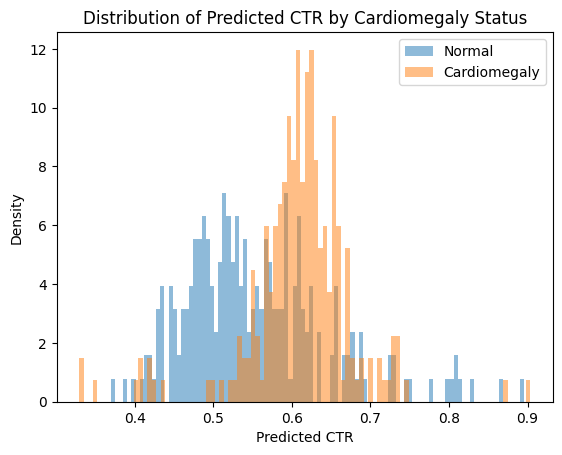

In [54]:

import matplotlib.pyplot as plt

# 1. Load your filled CSV
df = pd.read_csv("ctr_with_label_filled.csv")

# 2. Split by label
ctr_normal = df.loc[df.Cardiomegaly == 0, "ctr_pred"]
ctr_cm     = df.loc[df.Cardiomegaly == 1, "ctr_pred"]

# 3. Plot density histograms
plt.figure()
plt.hist(ctr_normal, bins=100, density=True, alpha=0.5, label="Normal")
plt.hist(ctr_cm,     bins=100, density=True, alpha=0.5, label="Cardiomegaly")
plt.xlabel("Predicted CTR")
plt.ylabel("Density")
plt.title("Distribution of Predicted CTR by Cardiomegaly Status")
plt.legend()
plt.show()


### Outlier Remove by IQR

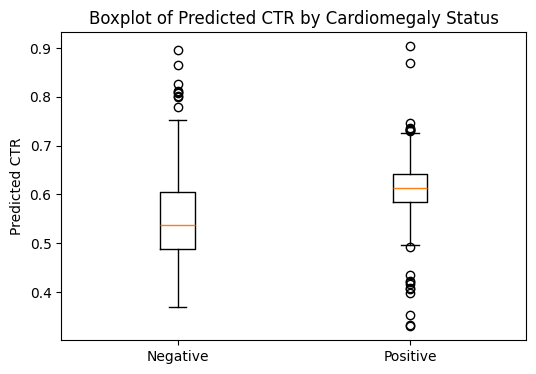

In [55]:
# 1) Boxplot of CTR by group
plt.figure(figsize=(6,4))
plt.boxplot([ctr_normal, ctr_cm], tick_labels=["Negative", "Positive"])
plt.ylabel("Predicted CTR")
plt.title("Boxplot of Predicted CTR by Cardiomegaly Status")
plt.show()

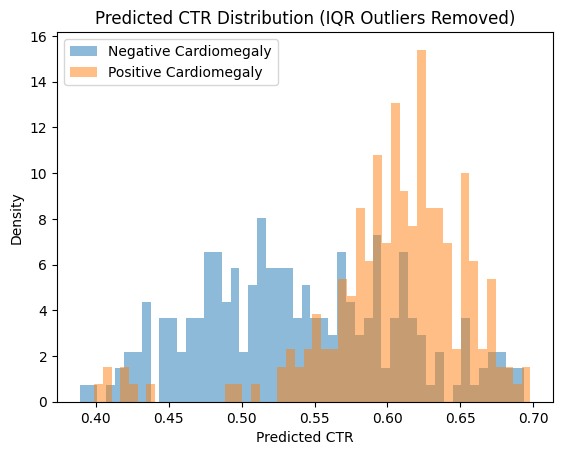

In [56]:
# Load data
df = pd.read_csv("ctr_with_label_filled.csv")

# Compute IQR for predicted CTR
ctr = df["ctr_pred"]
Q1 = ctr.quantile(0.25)
Q3 = ctr.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
df_filtered = df[(df["ctr_pred"] >= lower_bound) & (df["ctr_pred"] <= upper_bound)]

# Remove any samples with predicted CTR > 0.7
df_filtered = df_filtered[df_filtered["ctr_pred"] <= 0.7]

# Split by label
ctr_normal = df_filtered.loc[df_filtered.Cardiomegaly == 0, "ctr_pred"]
ctr_cm     = df_filtered.loc[df_filtered.Cardiomegaly == 1, "ctr_pred"]

# Plot distributions after outlier removal
plt.figure()
plt.hist(ctr_normal, bins=50, density=True, alpha=0.5, label="Negative Cardiomegaly")
plt.hist(ctr_cm,     bins=50, density=True, alpha=0.5, label="Positive Cardiomegaly")
plt.xlabel("Predicted CTR")
plt.ylabel("Density")
plt.title("Predicted CTR Distribution (IQR Outliers Removed)")
plt.legend()
plt.show()


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.metrics import roc_curve, auc

# Load the combined CTR + label CSV


# Split by cardiomegaly label
ctr_normal = df_filtered.loc[df.Cardiomegaly == 0, "ctr_pred"]
ctr_cm     = df_filtered.loc[df.Cardiomegaly == 1, "ctr_pred"]

# 2) Statistical tests
t_stat, p_t = ttest_ind(ctr_normal, ctr_cm, equal_var=False)
u_stat, p_u = mannwhitneyu(ctr_normal, ctr_cm, alternative="two-sided")
print(f"T-test: t = {t_stat:.3f}, p = {p_t:.3e}")
print(f"Mann-Whitney U: U = {u_stat:.3f}, p = {p_u:.3e}")


T-test: t = -11.543, p = 6.569e-27
Mann-Whitney U: U = 10405.500, p = 1.758e-25


Both tests show extremely significant differences between the two groups’ CTR distributions:

**Welch’s t-test**

$$
t = -11.543,\quad p \approx 6.6\times 10^{-27}
$$

which indicates the mean CTR for the normal group is substantially lower than for the cardiomegaly group, and the p-value is effectively zero, so we can reject the null hypothesis of equal means with overwhelming confidence.

**Mann–Whitney U test**

$$
U = 10405.5,\quad p \approx 1.8\times 10^{-25}
$$

showing that the two distributions differ significantly (not just their means), again with a vanishingly small p-value.


ROC AUC = 0.787
Optimal CTR threshold = 0.573 (Youden’s J)
Confusion Matrix (rows=true, cols=pred):
[[155  70]
 [ 38 179]]

Classification Report:
              precision    recall  f1-score   support

           0      0.803     0.689     0.742       225
           1      0.719     0.825     0.768       217

    accuracy                          0.756       442
   macro avg      0.761     0.757     0.755       442
weighted avg      0.762     0.756     0.755       442

Sensitivity (Recall) = 0.825


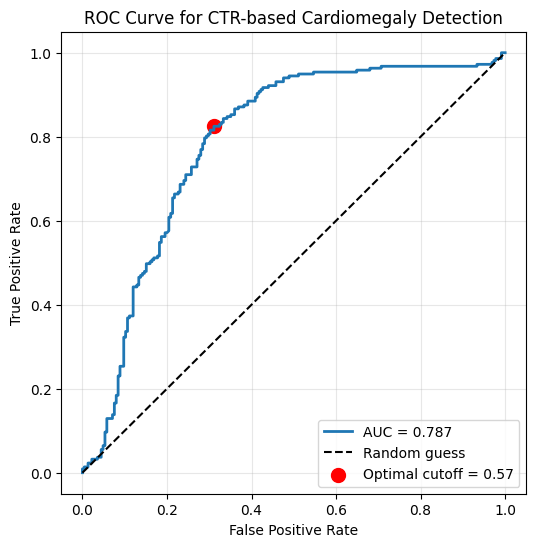

In [58]:
from sklearn.metrics import (
    roc_curve, auc,
    confusion_matrix,
    classification_report,
    recall_score
)


y_true  = df_filtered["Cardiomegaly"].values
y_score = df_filtered["ctr_pred"].values

# ROC & AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
recall = recall_score(y_true, y_pred)

# find optimal threshold via Youden's J
j_scores = tpr - fpr
ix = np.argmax(j_scores)
opt_thresh = thresholds[ix]
print(f"ROC AUC = {roc_auc:.3f}")
print(f"Optimal CTR threshold = {opt_thresh:.3f} (Youden’s J)")

# binary predictions at that threshold
y_pred = (y_score >= opt_thresh).astype(int)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (rows=true, cols=pred):")
print(cm)

# classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=3))
print(f"Sensitivity (Recall) = {recall:.3f}")

plt.figure(figsize=(6,6))
# Plot the ROC curve
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
# Plot the chance line
plt.plot([0,1], [0,1], 'k--', label="Random guess")
# Highlight the optimal point
plt.scatter(fpr[ix], tpr[ix],
            color='red', s=100,
            label=f"Optimal cutoff = {opt_thresh:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for CTR-based Cardiomegaly Detection")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

